<a href="https://colab.research.google.com/github/NinaNikolova/data_mining_project/blob/main/python_games3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mодел за прогнозиране на рейтинги на видео игри
## Mодел за логистична регресия, който предсказва рейтинги на видео игри

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving video_game_reviews.csv to video_game_reviews.csv


## Импортиране на библиотеки
- pandas и numpy - за работа с данни и числови операции
- matplotlib и seaborn - за визуализация на данните
- sklearn библиотеки - за създаване на модела за машинно обучение, предварителна обработка на данните и оценка на резултатите
##Зареждане на данните
- Зареждаме данните от CSV файл в променлива df (DataFrame). Тези данни съдържат информация за видео игри и техните рейтинги.
## Използва се Video Game Reviews and Ratings dataset:
https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('/content/video_game_reviews.csv')
data.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [ ]:

df_target = data["User Rating"]
columns_to_drop = ["User Rating", 'Developer', 'Publisher', 'Game Title','Price']

df= data.drop(columns=columns_to_drop)
df_attributes=pd.get_dummies(df, drop_first=True)

df_attributes.head()

,Release Year,Game Length (Hours),Min Number of Players,Age Group Targeted_All Ages,Age Group Targeted_Kids,Age Group Targeted_Teens,Platform_Nintendo Switch,Platform_PC,Platform_PlayStation,Platform_Xbox,...,"User Review Text_Disappointing game, but the gameplay is amazing.","User Review Text_Disappointing game, but the graphics could be better.","User Review Text_Disappointing game, but too many bugs.","User Review Text_Great game, but the gameplay is amazing.","User Review Text_Great game, but the graphics could be better.","User Review Text_Great game, but too many bugs.","User Review Text_Solid game, but the gameplay is amazing.","User Review Text_Solid game, but the graphics could be better.","User Review Text_Solid game, but too many bugs.",Game Mode_Online
0,2015,55.3,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,2015,34.6,3,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2012,13.9,5,False,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2015,41.9,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,2022,13.2,1,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


##Разделяне на данните за обучение и тестване при логистична регресия
- Когато работим с логистична регресия и други модели за машинно обучение, е от изключително значение правилно да разделим данните на тренировъчен и тестови набор.
Основни стъпки при подготовка на данните:
1.Превръщане на непрекъснатата целева променлива в категорийна - Когато имаме непрекъсната стойност, но искаме да приложим логистична регресия (която работи с класове), трябва първо да трансформираме целевата променлива. В нашия случай използваме медианата като праг
2.Разделяне на данните на тренировъчен и тестови набор
3.Обучение на модела с логистична регресия

In [ ]:
df_target_categorical = (df_target > df_target.median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    df_attributes,
    df_target_categorical,
    test_size=0.2,
    random_state=42  # For reproducibility
)
logistic_regression = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
logistic_regression.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
 ##Оценка на модела с тестовите данни

In [ ]:
# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7084

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      4793
           1       0.71      0.70      0.71      4762

    accuracy                           0.71      9555
   macro avg       0.71      0.71      0.71      9555
weighted avg       0.71      0.71      0.71      9555



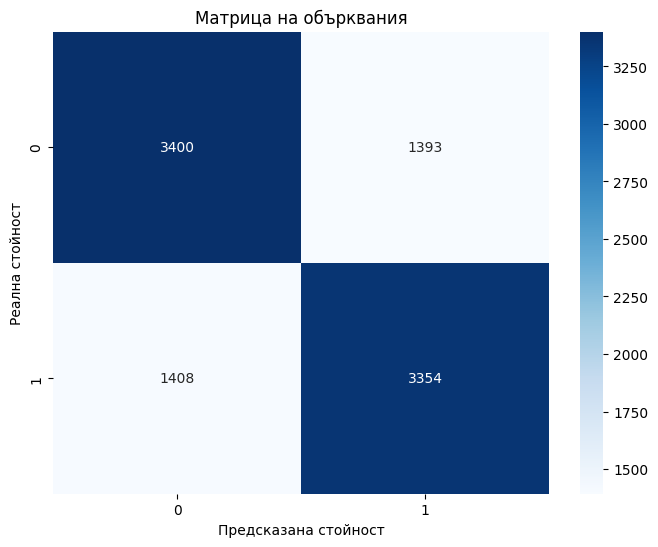

In [ ]:
# Визуализация на матрицата на обърквания
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказана стойност')
plt.ylabel('Реална стойност')
plt.title('Матрица на обърквания')
plt.show()


In [ ]:
# Анализ на важността на характеристиките
# Извличаме коефициентите от логистичния модел
feature_importance = pd.DataFrame({
    'Характеристика': df_attributes.columns,
    'Коефициент': logistic_regression.coef_[0]  # [0] защото при бинарна класификация има само един набор коефициенти
})
# Изчисляваме абсолютните стойности на коефициентите за сортиране
feature_importance['Абсолютна стойност'] = np.abs(feature_importance['Коефициент'])
# Сортираме по абсолютната стойност в низходящ ред
feature_importance = feature_importance.sort_values('Абсолютна стойност', ascending=False)

# Отпечатваме топ 10 характеристики
print("\nТоп 10 характеристики по важност:")
print(feature_importance.head(10))


Топ 10 характеристики по важност:
                                       Характеристика  Коефициент  \
37    User Review Text_Great game, but too many bugs.   -0.095409   
36  User Review Text_Great game, but the graphics ...    0.077663   
1                                 Game Length (Hours)    0.070270   
25                            Soundtrack Quality_Good    0.053855   
18                                       Genre_Sports   -0.052323   
38  User Review Text_Solid game, but the gameplay ...    0.050958   
33  User Review Text_Disappointing game, but the g...   -0.047671   
20                                    Multiplayer_Yes    0.045760   
5                            Age Group Targeted_Teens    0.044979   
13                                        Genre_Party    0.044704   

    Абсолютна стойност  
37            0.095409  
36            0.077663  
1             0.070270  
25            0.053855  
18            0.052323  
38            0.050958  
33            0.047671  
20   

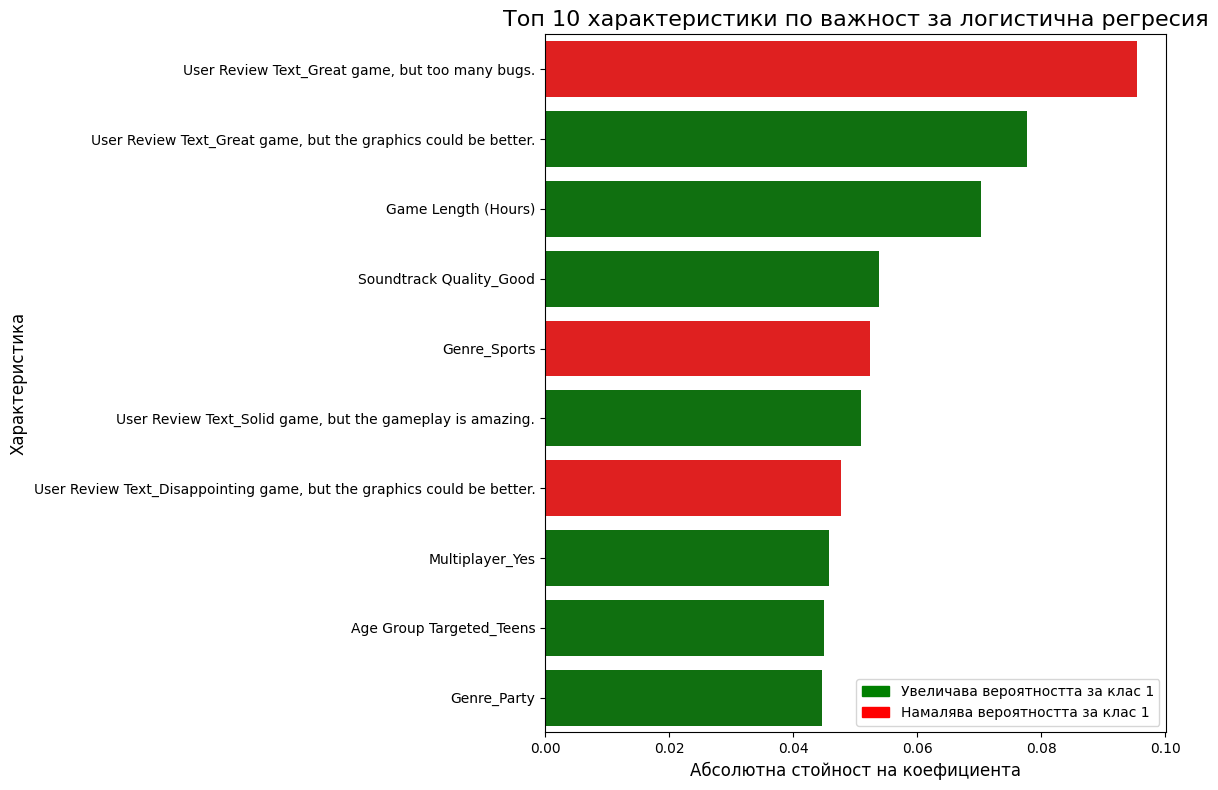

In [ ]:
# Стъпка 7: Визуализация на топ 10 характеристики
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
colors = ['green' if x > 0 else 'red' for x in top_features['Коефициент']]

sns.barplot(
    x='Абсолютна стойност',
    y='Характеристика',
    data=top_features,
    palette=colors
)
plt.title('Топ 10 характеристики по важност за логистична регресия', fontsize=16)
plt.xlabel('Абсолютна стойност на коефициента', fontsize=12)
plt.ylabel('Характеристика', fontsize=12)
# Добавяме легенда за положителни и отрицателни коефициенти
import matplotlib.patches as mpatches
pos_patch = mpatches.Patch(color='green', label='Увеличава вероятността за клас 1')
neg_patch = mpatches.Patch(color='red', label='Намалява вероятността за клас 1')
plt.legend(handles=[pos_patch, neg_patch])

plt.tight_layout()
plt.show()



In [ ]:
# Стъпка 8: Запазване на модела и скалиращия обект


# Запазваме модела
import joblib
joblib.dump(logistic_regression, 'logistic_regression_model.pkl')

print("\nМоделът е успешно запазен в 'logistic_regression_model.pkl'")



Моделът е успешно запазен в 'logistic_regression_model.pkl'
